In [1]:
import os
import re

from rdkit import Chem
from openbabel import pybel
import parameter_extractor as pe
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

IPythonConsole.molSize = (300, 300)  # Change image size
DrawingOptions.bondLineWidth = 1.8

In [70]:
filename = "l_4_SPE"
comp = pe.ParameterExtractor(filename)
sorted([(a.GetSymbol(), a.GetIdx() + 1) for a in comp.cod], key=lambda x: x[1])

Rh 34 - C 24 : Bond not found
Rh 34 - C 22 : Bond not found
Rh 34 - C 14 : Bond not found
Rh 34 - C 12 : Bond not found
Rh 34 - C 24 : Antibond not found
Rh 34 - C 22 : Antibond not found
Rh 34 - C 14 : Antibond not found
Rh 34 - C 12 : Antibond not found


[('C', 12),
 ('H', 13),
 ('C', 14),
 ('H', 15),
 ('C', 16),
 ('H', 17),
 ('H', 18),
 ('C', 19),
 ('H', 20),
 ('H', 21),
 ('C', 22),
 ('H', 23),
 ('C', 24),
 ('H', 25),
 ('C', 26),
 ('H', 27),
 ('H', 28),
 ('C', 29),
 ('H', 30),
 ('H', 31)]

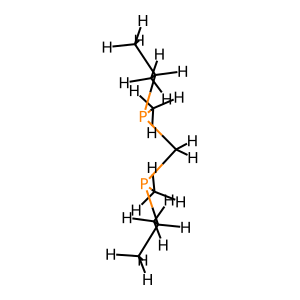

In [49]:
editable_mol = Chem.RWMol(comp.mol)
cod_idx = [a.GetIdx() for a in comp.cod]
remove_atoms = [a for a in editable_mol.GetAtoms() if a.GetIdx() in cod_idx]
remove_atoms.append(comp.rh)
remove_atoms = sorted(remove_atoms, key=lambda x: x.GetIdx(), reverse=True)
for atom in remove_atoms:
    atom.SetAtomMapNum(atom.GetIdx())
    editable_mol.RemoveAtom(atom.GetIdx())
editable_mol

In [68]:
ligand_number = re.search(r"\d+[a-z]*", filename)[0]
ligand_number

'44'

In [73]:
pdb_block = Chem.MolToPDBBlock(editable_mol)
pdb = pybel.readstring("pdb", pdb_block)
gjf = pdb.write("gjf")
gjf = re.sub(r"!Put Keywords Here, check Charge and Multiplicity.\n#\n\n",
             fr"%nprocshared=14\n%mem=8GB\n# nmr=giao b3lyp/def2TZVP pop=nbo scfcyc=200\n\nLigand {ligand_number} SPE NoRh",
             gjf)
with open(f"l_{ligand_number}_SPE_NoRh.gjf", "w") as f:
    f.write(gjf)

In [ ]:
submit_filename = f"l_{ligand_number}_SPE_NoRh"
submit_file = f"""
#!/bin/csh
#$ -N {submit_filename}
#$ -pe smp 14
#$ -q iqtc08.q
#$ -S /bin/csh
#$ -cwd
#$ -o $HOME/javier/{submit_filename}.log
#$ -e $HOME/javier/{submit_filename}.err
#$ -m e  
#$ -M javier.eusamio@ub.edu 

# Load the modules needed
source /etc/profile.d/modules.csh
module load gaussian/g16b01

cd $TMPDIR
cp -pr $HOME/javier/{submit_filename}.gjf .

# Run the job
g16 < {submit_filename}.gjf > {submit_filename}.out

# Copy the results to our home directory
cp {submit_filename}.out $HOME/javier/
"""
with open(submit_filename, "w") as f:
    f.write(submit_file)

In [80]:
os.listdir("./out/spe")

['l_10_SPE.out',
 'l_11_SPE.out',
 'l_12_SPE.out',
 'l_13_SPE.out',
 'l_18_SPE.out',
 'l_19_SPE.out',
 'l_1_SPE.out',
 'l_2_SPE.out',
 'l_3_SPE.out',
 'l_4_SPE.out',
 'l_5_SPE.out',
 'l_6_SPE.out',
 'l_7_SPE.out',
 'l_8_SPE.out']

In [2]:
for file in os.listdir("./out/spe"):
    filename = file.split(".")[0]
    ligand_number = re.search(r"\d+[a-z]*", file)[0]
    submit_filename = f"l_{ligand_number}_SPE_NoRh"
    submit_file = f"""#!/bin/csh
#$ -N {submit_filename}
#$ -pe smp 14
#$ -q iqtc08.q
#$ -S /bin/csh
#$ -cwd
#$ -o $HOME/javier/{submit_filename}.log
#$ -e $HOME/javier/{submit_filename}.err
#$ -m e  
#$ -M javier.eusamio@ub.edu 

# Load the modules needed
source /etc/profile.d/modules.csh
module load gaussian/g16b01

cd $TMPDIR
cp -pr $HOME/javier/{submit_filename}.gjf .

# Run the job
g16 < {submit_filename}.gjf > {submit_filename}.out

# Copy the results to our home directory
cp {submit_filename}.out $HOME/javier/"""
    comp = pe.ParameterExtractor(filename)
    editable_mol = Chem.RWMol(comp.mol)
    cod_idx = [a.GetIdx() for a in comp.cod]
    remove_atoms = [a for a in editable_mol.GetAtoms() if a.GetIdx() in cod_idx]
    remove_atoms.append(comp.rh)
    remove_atoms = sorted(remove_atoms, key=lambda x: x.GetIdx(), reverse=True)
    for atom in remove_atoms:
        atom.SetAtomMapNum(atom.GetIdx())
        editable_mol.RemoveAtom(atom.GetIdx())
    pdb_block = Chem.MolToPDBBlock(editable_mol)
    pdb = pybel.readstring("pdb", pdb_block)
    gjf = pdb.write("gjf")
    gjf = re.sub(
        r"!Put Keywords Here, check Charge and Multiplicity.\n#\n\n",
        fr"%nprocshared=14\n%mem=8GB\n# nmr=giao b3lyp/def2TZVP pop=nbo scfcyc=200\n\nLigand {ligand_number} SPE NoRh",
        gjf
    )
    with open(f"./gjf/NoRh/l_{ligand_number}_SPE_NoRh.gjf", "w") as f:
        f.write(gjf)
    with open(f"./gjf/NoRh/{submit_filename}", "w", newline='\n') as f:
        f.write(submit_file)
    print(f"Ligand {ligand_number} done!")

Ligand 10 done!
Ligand 11 done!
Ligand 12 done!
Ligand 13 done!
Ligand 18 done!
Ligand 19 done!
Ligand 1 done!
Ligand 20b done!
Ligand 21 done!
Ligand 22 done!
Ligand 23 done!
Ligand 24 done!
Ligand 25 done!
Ligand 26 done!
Ligand 27 done!
Ligand 28 done!
Ligand 29 done!
Ligand 2 done!
Ligand 30 done!
Ligand 31 done!
Ligand 32a done!
Ligand 33c done!
Ligand 34 done!
Ligand 35 done!
Ligand 36 done!
Ligand 37c done!
Ligand 38 done!
Ligand 39 done!
Ligand 3 done!
Ligand 40 done!
Ligand 41 done!
Ligand 42 done!
Ligand 43 done!
Ligand 44 done!
Ligand 45 done!
Ligand 46 done!
Ligand 47 done!
Ligand 48 done!
Ligand 49 done!
Ligand 4 done!
Ligand 50 done!
Ligand 51b done!
Ligand 52 done!
Ligand 53 done!
Ligand 57a done!
Ligand 58 done!
Ligand 59 done!
Ligand 5 done!
Ligand 60 done!
Ligand 61 done!
Ligand 62 done!
Ligand 63 done!
Ligand 64a done!
Ligand 65b done!
Ligand 6 done!
Ligand 72 done!
Ligand 73 done!
Ligand 74 done!
Ligand 75 done!
Ligand 76 done!
Ligand 77 done!
Ligand 7 done!
Ligand 

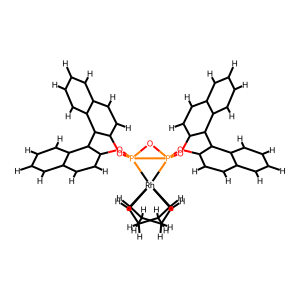

In [17]:
from rdkit.Chem import rdDetermineBonds
with open(f"./out/spe/{filename}.out") as f:
    __out = f.readlines()
mol = next(pybel.readfile("out", f"./out/spe/{filename}.out"))
xyz = mol.write("xyz")
mol = Chem.MolFromXYZBlock(xyz)
rdDetermineBonds.DetermineConnectivity(mol)
mol